In [27]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
from manapy.solvers.ls import PETScKrylovSolver
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  domain = Domain(dim=dim, conf=running_conf)
  faces = domain.faces
  cells = domain.cells
  halos = domain.halos
  nodes = domain.nodes

  nbnodes = domain.nbnodes
  nbfaces = domain.nbfaces
  nbcells = domain.nbcells
  backend = domain.backend
  signature = domain.signature

  test_para = 'test_2'

  if test_para == "test_1" :
      fi    = 0.81
      U_n  = 3.e-3
      Pin = 1e5
      perm0 = 6.83e-9
      mu0 = 0.3
      tfinal = 122

      test = "pression"
      filename = "Geom_exp3.msh"


  if test_para == "test_2" :
      C0 = 0.
      alpha0 = 1.
      sigma_u = 0.85
      a = 1.
      A = 0.68
      Pin = 3e5
      mu0  = 0.109
      fi0 =  0.45
      U_n  = 1e-1
      tfinal = 1000

      test = "pression"
      filename = "TMesh.msh"

  boundariesI = {"in" : "dirichlet",
                  "out" : "neumann",
                  "upper":"neumann",
                  "bottom":"neumann"
              }
  valuesI = {"in" : 1}

  I = Variable(domain=domain, BC=boundariesI, values=valuesI,  terms = ["Flux"])
  I.update_ghost_value()

  # Concentration
  boundariesC = {"in" : "dirichlet",
                  "out" : "neumann",
                  "upper":"neumann",
                  "bottom":"neumann"
              }
  valuesC = {"in" : C0}
  C = Variable(domain=domain, BC=boundariesC, values=valuesC,  terms = ["Flux"])
  C.update_ghost_value()

  fiC = Variable(domain=domain, terms = ["Flux"])

  perm_x_0  = Variable(domain=domain)
  perm_y_0  = Variable(domain=domain)

  perm_x  = Variable(domain=domain)
  perm_y  = Variable(domain=domain)

  visc  = Variable(domain=domain)
  fi  = Variable(domain=domain)
  sigma = Variable(domain=domain)
  alpha = Variable(domain=domain)

  ## initialization of viscosity, porosity and filtration coieficient
  visc.cell[:]  = mu0
  fi.cell[:]  = fi0
  alpha.cell[:] = alpha0
  visc.update_ghost_value()
  fi.update_ghost_value()
  alpha.update_ghost_value()

  ## initialization of the permeability
  for i in range(nbcells):
      if cells.center[i][1] >= 0.0014:
          perm_x_0.cell[i] =  4.e-11
          perm_y_0.cell[i] =  2.e-11

      else:
          perm_x_0.cell[i] =  2.e-11
          perm_y_0.cell[i] =  4.e-11

  # Perm changes over time
  perm_x.cell[:] = perm_x_0.cell[:]
  perm_y.cell[:] = perm_y_0.cell[:]

  perm_x.update_ghost_value()
  perm_y.update_ghost_value()

  ## injection mode
  if test == "pression":
      boundariesP = {"in" : "dirichlet",
                    "out" : "dirichlet",
                    "upper":"neumann",
                    "bottom":"neumann"
                  }
      valuesP = {"in" : Pin, "out": 0. }
      boundariesU = {"in" : "neumann",
                    "out" : "neumann",
                    "upper":"noslip",
                    "bottom":"noslip"}
      
      u  = Variable(domain=domain, BC=boundariesU)
      v  = Variable(domain=domain, BC=boundariesU)


  elif test == "debit":
      boundariesP = {"in" : "neumannNH",
                    "out" : "dirichlet",
                    "upper":"neumann",
                    "bottom":"neumann"
                  }
      cst = (mu0/perm0)*U_n
      valuesP = {"in" : cst, "out": 0. }

      boundariesU = {"in" : "dirichlet",
                    "out" : "neumann",
                    "upper":"neumann",
                    "bottom":"neumann"
                  }
      valuesU = {"in": U_n}
      u  = Variable(domain=domain)#, BC=boundariesU, values=valuesU)

  v  = Variable(domain=domain)
  w  = Variable(domain=domain)

  P = Variable(domain=domain, BC=boundariesP, values=valuesP)
  Pexact = Variable(domain=domain)
  Iexact = Variable(domain=domain)


  for i in domain.infaces:
      K = faces.cellid[i][0]
      I.cell[K] = 1.

  x0    = 0.
  cst = 0.
  time = 0
  miter = 0
  niter = 1
  saving_at_node = 1
  order = 2
  cfl = 0.8
  alpha_para = 2e-6

  dissip_I = np.zeros(nbcells)
  src_C = np.zeros(nbcells)
  src_I = np.zeros(nbcells)
  div = np.zeros(nbcells)

  conf = Struct(reuse_mtx=False, with_mtx=True, scheme='diamond', verbose=False, 
                precond='gamg', sub_precond="amg",
                eps_a=1e-10, eps_r=1e-10, method="gmres")
                
  L = PETScKrylovSolver(domain=domain, var=P, conf=conf)

  L.update_ghost_values()
  L.var.BCdirichlet = L.domain.nodes.oldname

  Errors = []
  Times = []
  x_front = []
  c = 1
  d_t = 1e-4

  return (domain, L, P, I, alpha_para, nbcells, visc, faces, cst)

In [28]:
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre_hybrid.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square_larger.msh"
domain, L, P, I, alpha_para, nbcells, visc, faces, cst = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...
SetUp the Linear system ...


In [29]:
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))


host_cellfid, d_cellfid = create_var(domain.faces.cellid)
host_nodeidf, d_nodeidf = create_var(domain.faces.nodeid)
host_oldname, d_oldname = create_var(domain.nodes.oldname)
host_volume, d_volume = create_var(domain.cells.volume)
host_centergn, d_centergn = create_var(domain.nodes.ghostcenter)
host_loctoglob, d_loctoglob = create_var(domain.cells.loctoglob)
host_param1, d_param1 = create_var(domain.faces.param1)
host_param2, d_param2 = create_var(domain.faces.param2)
host_param3, d_param3 = create_var(domain.faces.param3)
host_param4, d_param4 = create_var(domain.faces.param4)
host_Pbordnode, d_Pbordnode = create_var(domain.Pbordnode)
host_Pbordface, d_Pbordface = create_var(domain.Pbordface)
host_rhs, d_rhs = create_var(L.rhs0)
host_BCdirichlet, d_BCdirichlet = create_var(P.BCdirichlet)
host_centergf, d_centergf = create_var(domain.faces.ghostcenter)
host_matrixinnerfaces, d_matrixinnerfaces = create_var(L.matrixinnerfaces)
host_halofaces, d_halofaces = create_var(domain.halofaces)
host_dirichletfaces, d_dirichletfaces = create_var(P.dirichletfaces)
host_neumannNHfaces, d_neumannNHfaces = create_var(P.neumannNHfaces)
host_Icell, d_Icell = create_var(I.cell)
host_Inode, d_Inode = create_var(I.node)
host_perm_vec, d_perm_vec = create_var(np.ones(nbcells))
host_visc_vec, d_visc_vec = create_var(visc.cell)
host_cst, d_cst = cst, cst
host_mesuref, d_mesuref = create_var(faces.mesure)
host_normalf, d_normalf = create_var(faces.normal)
host_dist, d_dist = create_var(faces.dist_ortho)



In [30]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np

def get_rhs_glob_2d_with_contrib(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', oldname:'uint32[:]', 
                                 volume:'float[:]', centergn:'float[:,:,:]', loctoglob:'int32[:]', 
                                 param1:'float[:]', param2:'float[:]', 
                                 param3:'float[:]', param4:'float[:]', Pbordnode:'float[:]', 
                                 Pbordface:'float[:]',  rhs:'float[:]',
                                 BCdirichlet:'uint32[:]', centergf:'float[:,:]', matrixinnerfaces:'uint32[:]',
                                 halofaces:'uint32[:]', dirichletfaces:'uint32[:]', neumannNHfaces:'uint32[:]', 
                                 Icell:'float[:]', Inode:'float[:]', perm_vec:'float[:]', visc_vec:'float[:]',
                                 cst:'float', mesuref:'float[:]', normalf:'float[:,:]', dist:'float[:]'):  
    
    def search_element(a:'int32[:]', target_value:'int32'):
        find = 0
        for val in a:
            if val == target_value:
                find = 1
                break
        return find
    
    rhs[:] = 0.
    for i in matrixinnerfaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        

        perm = 0.5 * (perm_vec[c_rightglob] + perm_vec[c_leftglob])
        visc = 0.5 * (visc_vec[c_rightglob] + visc_vec[c_leftglob])

        perm_visc = perm / visc

        # perm = dist[i][0]/(dist[i][1]/perm_vec[c_rightglob] + dist[i][2]/perm_vec[c_leftglob])
        # visc = dist[i][0]/(dist[i][1]/visc_vec[c_rightglob] + dist[i][2]/visc_vec[c_leftglob])

        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            VL = Pbordnode[i_1]*Icell[c_left]*(perm_visc)
            value_left = -1. * VL * param4[i] / volume[c_left]
            rhs[c_leftglob] +=  value_left
            
            VR = Pbordnode[i_1]*Icell[c_right]*(perm_visc)
            value_right = VR * param4[i] / volume[c_right]
            rhs[c_rightglob] += value_right
            
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            VL = Pbordnode[i_2]*Icell[c_left]*(perm_visc)
            value_left =  -1. * VL * param2[i] / volume[c_left]
            rhs[c_leftglob] += value_left
            
            VR = Pbordnode[i_2]*Icell[c_right]*(perm_visc)
            value_right =  VR * param2[i] / volume[c_right]
            rhs[c_rightglob] += value_right
                    
    for i in halofaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]

        perm = perm_vec[c_leftglob] 
        visc = visc_vec[c_leftglob]

        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            VL = Pbordnode[i_1]*Icell[c_left]*(perm/visc)
            value_left =  -1. * VL * param4[i] / volume[c_left]
            rhs[c_leftglob] += value_left
        
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            VR = Pbordnode[i_2]*Icell[c_left]*(perm/visc)
            value_left =  -1. * VR * param2[i] / volume[c_left]
            rhs[c_leftglob] += value_left
            
    for i in dirichletfaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        perm = perm_vec[c_leftglob] 
        visc = visc_vec[c_leftglob]

        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]  
        
        if centergn[i_1][0][2] != -1:     
            VL = Pbordnode[i_1]*Icell[c_left]*(perm/visc)
            value_left = -1. * VL * param4[i] / volume[c_left]
            rhs[c_leftglob] += value_left
           
        if centergn[i_2][0][2] != -1: 
            VL = Pbordnode[i_2]*Icell[c_left]*(perm/visc)
            value_left = -1. * VL * param2[i] / volume[c_left]
            rhs[c_leftglob] += value_left
        
        V_K = Pbordface[i]*Icell[c_left]*(perm/visc)
        value = -2. * param3[i] / volume[c_left] * V_K
        rhs[c_leftglob] += value
        
    for i in neumannNHfaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]

        perm = perm_vec[c_left] 
        visc = visc_vec[c_left]
        rhs[c_leftglob] -= 1 * Icell[c_left]*(perm/visc)*cst*(np.sqrt(normalf[i][0]**2+normalf[i][1]**2))/volume[c_left]
        

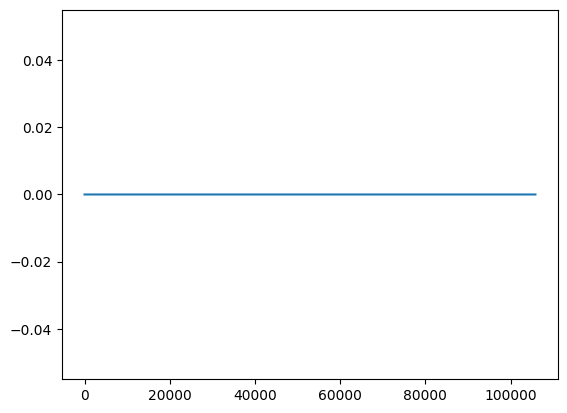

In [33]:
plt.plot(host_rhs)

In [31]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_get_rhs_glob_2d_with_contrib = numba.jit(get_rhs_glob_2d_with_contrib, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_get_rhs_glob_2d_with_contrib():
  return numba_get_rhs_glob_2d_with_contrib(
    host_cellfid,
    host_nodeidf,
    host_oldname,
    host_volume,
    host_centergn,
    host_loctoglob,
    host_param1,
    host_param2,
    host_param3,
    host_param4,
    host_Pbordnode,
    host_Pbordface,
    host_rhs,
    host_BCdirichlet,
    host_centergf,
    host_matrixinnerfaces,
    host_halofaces,
    host_dirichletfaces,
    host_neumannNHfaces,
    host_Icell,
    host_Inode,
    host_perm_vec,
    host_visc_vec,
    host_cst,
    host_mesuref,
    host_normalf,
    host_dist,
  )


In [13]:
#time taken by cpu_get_rhs_glob_2d_with_contrib


cpu_get_rhs_glob_2d_with_contrib()
test_time(70, cpu_get_rhs_glob_2d_with_contrib)

4.65276 ms


In [24]:
@cuda.jit(device=True)
def search_element(a:'int32[:]', target_value:'int32'):
    for i in range(a.shape[0]):
        if a[i] == target_value:
            return 1
    return 0

@cuda.jit()
def kernel_get_rhs_glob_2d_with_contrib(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', oldname:'uint32[:]', 
                                 volume:'float[:]', centergn:'float[:,:,:]', loctoglob:'int32[:]', 
                                 param1:'float[:]', param2:'float[:]', 
                                 param3:'float[:]', param4:'float[:]', Pbordnode:'float[:]', 
                                 Pbordface:'float[:]',  rhs:'float[:]',
                                 BCdirichlet:'uint32[:]', centergf:'float[:,:]', matrixinnerfaces:'uint32[:]',
                                 halofaces:'uint32[:]', dirichletfaces:'uint32[:]', neumannNHfaces:'uint32[:]', 
                                 Icell:'float[:]', Inode:'float[:]', perm_vec:'float[:]', visc_vec:'float[:]',
                                 cst:'float', mesuref:'float[:]', normalf:'float[:,:]', dist:'float[:]'):  
    

    
    #? rhs[:] = 0.

    idx = cuda.grid(1)

    if idx < matrixinnerfaces.shape[0]:
        i = matrixinnerfaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        

        perm = 0.5 * (perm_vec[c_rightglob] + perm_vec[c_leftglob])
        visc = 0.5 * (visc_vec[c_rightglob] + visc_vec[c_leftglob])

        perm_visc = perm / visc

        # perm = dist[i][0]/(dist[i][1]/perm_vec[c_rightglob] + dist[i][2]/perm_vec[c_leftglob])
        # visc = dist[i][0]/(dist[i][1]/visc_vec[c_rightglob] + dist[i][2]/visc_vec[c_leftglob])

        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            VL = Pbordnode[i_1]*Icell[c_left]*(perm_visc)
            value_left = -1. * VL * param4[i] / volume[c_left]
            #? rhs[c_leftglob] +=  value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)
            
            VR = Pbordnode[i_1]*Icell[c_right]*(perm_visc)
            value_right = VR * param4[i] / volume[c_right]
            #? rhs[c_rightglob] += value_right
            cuda.atomic.add(rhs, c_rightglob, value_right)

            
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            VL = Pbordnode[i_2]*Icell[c_left]*(perm_visc)
            value_left =  -1. * VL * param2[i] / volume[c_left]
            #? rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)

            
            VR = Pbordnode[i_2]*Icell[c_right]*(perm_visc)
            value_right =  VR * param2[i] / volume[c_right]
            #? rhs[c_rightglob] += value_right
            cuda.atomic.add(rhs, c_rightglob, value_right)

                    
    if idx < halofaces.shape[0]:
        i = halofaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]

        perm = perm_vec[c_leftglob] 
        visc = visc_vec[c_leftglob]

        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            VL = Pbordnode[i_1]*Icell[c_left]*(perm/visc)
            value_left =  -1. * VL * param4[i] / volume[c_left]
            #? rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)

        
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            VR = Pbordnode[i_2]*Icell[c_left]*(perm/visc)
            value_left =  -1. * VR * param2[i] / volume[c_left]
            #? rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)

            
    if idx < dirichletfaces.shape[0]:
        i = dirichletfaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        perm = perm_vec[c_leftglob] 
        visc = visc_vec[c_leftglob]

        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]  
        
        if centergn[i_1][0][2] != -1:     
            VL = Pbordnode[i_1]*Icell[c_left]*(perm/visc)
            value_left = -1. * VL * param4[i] / volume[c_left]
            #? rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)

           
        if centergn[i_2][0][2] != -1: 
            VL = Pbordnode[i_2]*Icell[c_left]*(perm/visc)
            value_left = -1. * VL * param2[i] / volume[c_left]
            #? rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)

        
        V_K = Pbordface[i]*Icell[c_left]*(perm/visc)
        value = -2. * param3[i] / volume[c_left] * V_K
        #? rhs[c_leftglob] += value
        cuda.atomic.add(rhs, c_leftglob, value)

        
    if idx < neumannNHfaces.shape[0]:
        i = neumannNHfaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]

        perm = perm_vec[c_left] 
        visc = visc_vec[c_left]
        #?  rhs[c_leftglob] -= 1 * Icell[c_left]*(perm/visc)*cst*(np.sqrt(normalf[i][0]**2+normalf[i][1]**2))/volume[c_left]
        v = (normalf[i][0]**2+normalf[i][1]**2) ** (0.5)
        v = -1 * Icell[c_left]*(perm/visc)*cst*(v)/volume[c_left]
        cuda.atomic.add(rhs, c_leftglob, v)

        




In [25]:
import numba


nb_element = max(
    d_matrixinnerfaces.shape[0],
    d_halofaces.shape[0],
    d_dirichletfaces.shape[0],
    d_neumannNHfaces.shape[0],
  )

nb_threads = 32
nb_blocks = nb_element // nb_threads + 1
print(nb_blocks)

@cuda.jit
def kernel_zero(arr_out):
  i = cuda.grid(1)
  if i < arr_out.shape[0]:
    arr_out[i] = 0

def cuda_get_rhs_glob_2d_with_contrib():
  kernel_zero[d_rhs.shape[0] // nb_threads + 1, nb_threads](d_rhs)
  cuda.synchronize()
  kernel_get_rhs_glob_2d_with_contrib[nb_blocks, nb_threads](
    d_cellfid,
    d_nodeidf,
    d_oldname,
    d_volume,
    d_centergn,
    d_loctoglob,
    d_param1,
    d_param2,
    d_param3,
    d_param4,
    d_Pbordnode,
    d_Pbordface,
    d_rhs,
    d_BCdirichlet,
    d_centergf,
    d_matrixinnerfaces,
    d_halofaces,
    d_dirichletfaces,
    d_neumannNHfaces,
    d_Icell,
    d_Inode,
    d_perm_vec,
    d_visc_vec,
    d_cst,
    d_mesuref,
    d_normalf,
    d_dist,
  )
  cuda.synchronize()

cuda_get_rhs_glob_2d_with_contrib()
test_time(70, cuda_get_rhs_glob_2d_with_contrib)

4949
1.02327 ms


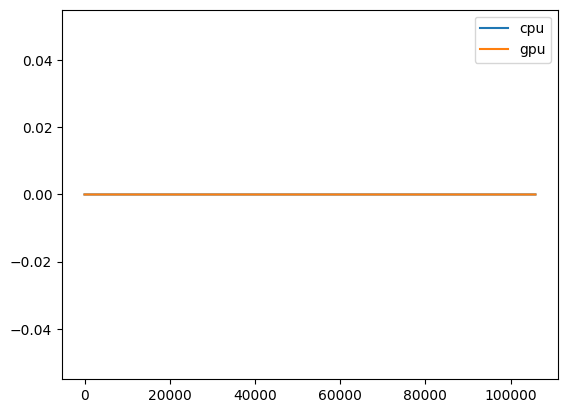

In [26]:
#verify

def verify(a, b, decimal, plot):
  if plot == True:
    plt.plot(a, label="cpu")
    plt.plot(b, label="gpu")
    plt.legend()
    plt.show()
  np.testing.assert_almost_equal(a, b, decimal=decimal, )


verify(host_rhs, d_rhs.copy_to_host(), decimal=2, plot=True)